In [45]:
import cv2
import numpy as np
import numpy.linalg as npl
from matplotlib import pyplot as plt
from matplotlib import cbook

## Image loading
 Run the cell below to load the **image** and image **normals**, and plot them side by side
 Note that our image values are RGB in the range $[0, 1)$
 We will convert this to HSV so that we can more easily adjust luminance (by modifying V)

In [1]:
image = plt.imread('./data/mid_level_examples/church/input.png')
normals = plt.imread('./data/mid_level_examples/church/normals.png')

fig, ax = plt.subplot_mosaic([['image', 'normals']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['normals'].imshow(normals)
ax['normals'].axis('off')
ax['normals'].set_title('Normals')

#light_source = [(16, 14)]
#x, y = zip(*light_source)
#ax['image'].plot(x, y, 'o')

plt.show()

NameError: name 'plt' is not defined

Now we will implicitly define a radial light source

In [116]:
class LightSource:
    def __init__(self):
        self.origin = np.array([250, 250])
        self.radius = 125

    def _query(self, coordinate, alpha=0.05):
        euclidean_distance = npl.norm(self.origin - coordinate)
        if euclidean_distance > self.radius:
            return 0
        else:
            return 1.0 / (1 + alpha * euclidean_distance)

    def draw_image(self, image):
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for i, _ in enumerate(image_hsv[0]):
            for j, _ in enumerate(image_hsv[1]):
                light_v = self._query(np.array([i, j]))
                image_hsv[i, j, 2] += light_v
        image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
        return image_rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


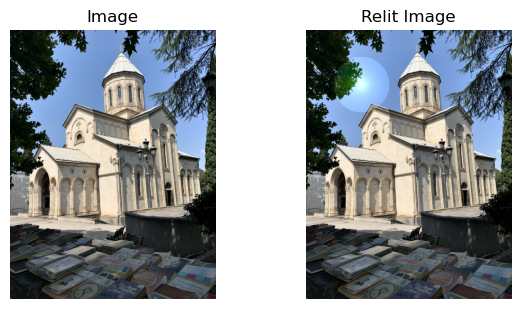

In [117]:
light = LightSource()

image_relit = light.draw_image(image)

fig, ax = plt.subplot_mosaic([['image', 'image_relit']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['image_relit'].imshow(image_relit)
ax['image_relit'].axis('off')
ax['image_relit'].set_title('Relit Image')

markers = [(250, 250)]
x, y = zip(*markers)
# ax['image_relit'].plot(x, y, 'o')

plt.show()